# Grade: /100 pts
# Assignment 8: Customer Segmentation with Clustering

In this assignment, you will be solving a traditional problem in quantitative marketing: customer segmentation. Having a properly segmented database is extremely important to define marketing campaigns, as it allows companies to define value-centric actions targeted towards customers of different profiles. In this ocassion you are going to analyze customers of an automobile company.

Assume you are the owner of a consulting company that is in charge of this project. In this assignment you are going to conduct 2 different strategies for segmentating the potential customers.

The information is provided in the document `DATA.csv` which has the following columns:

- **ID:** Customer identifier (it does not have prediction power).
- **Gender:** Gender of a customer.
- **Ever_Married**: Potential customer's marrige status.
- **Age**: Potential customer's age.
- **Graduated:** Education status of the customer.
- **Profession:** Type of customer's career.
- **Work_Experience:** Work experience in years.
- **Spending_Score:** Level of customer's spending power.
- **Family_Size:** Number of family members for the customer.
- **Var_1:** Anonymised Category for the customer.


### Follow These Steps before submitting
Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline. 

5.  Your submission document should be saved in the form: `LastName_FirstName_Assignment9.ipynb`


In [1]:
pip install yellowbrick

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering, KMeans
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
 
from yellowbrick.cluster.elbow import kelbow_visualizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from sklearn import preprocessing
from sklearn.decomposition import PCA
import seaborn as sns
import itertools
%matplotlib inline

## Question 1 Loading the data and Preprocessing (10 pts)


1. Import the data. Report the data shape. How many null values in each column?

In [3]:
df = pd.read_csv("DATA.csv")
print("Null values per column:\n", df.isnull().sum())

Null values per column:
 ID                   0
Gender               0
Ever_Married       140
Age                  0
Graduated           78
Profession           0
Work_Experience    829
Spending_Score       0
Family_Size        335
Var_1               76
dtype: int64


In [4]:
df.shape
df.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4
1,462643,Female,Yes,38,Yes,Engineer,NaN,Average,3.0,Cat_4
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6
3,461735,Male,Yes,67,Yes,Other,0.0,High,2.0,Cat_6
4,462669,Female,Yes,40,Yes,Entertainment,NaN,High,6.0,Cat_6


2. For the column `Work_Experience` and `Family_Size`, use median value to replace the null values. For each of other columns with null entries, use the most frequent level in a column to replace the null values in this column.

In [5]:
df['Work_Experience'].fillna(df['Work_Experience'].median(), inplace=True)
df['Family_Size'].fillna(df['Family_Size'].median(), inplace=True)

# replace null values in other columns with most frequent value
for column in df.columns:
    if df[column].isnull().sum() > 0 and column not in ['Work_Experience', 'Family_Size']:
        most_frequent_value = df[column].mode()[0]
        df[column].fillna(most_frequent_value, inplace=True)

In [6]:
print("Null values per column:\n", df.isnull().sum())

Null values per column:
 ID                 0
Gender             0
Ever_Married       0
Age                0
Graduated          0
Profession         0
Work_Experience    0
Spending_Score     0
Family_Size        0
Var_1              0
dtype: int64


3. Using `preprocessing.OneHotEncoder()`, convert all categorical features. Make sure not to add collinear features during the encoding process. Then, display the first 10 rows.

In [7]:
categorical_features = ['Gender', 'Ever_Married', 'Graduated', 'Profession', 'Spending_Score','Var_1']
encoder = preprocessing.OneHotEncoder(drop='first', sparse=False)

encoded_features = encoder.fit_transform(df[categorical_features])
encoded_data = pd.DataFrame(encoded_features, columns=encoder.get_feature_names(categorical_features))
data = pd.concat([df.drop(columns=categorical_features), encoded_data], axis=1)

print(data.head(10))

       ID  Age  Work_Experience  Family_Size  Gender_Male  Ever_Married_Yes  \
0  462809   22              1.0          4.0          1.0               0.0   
1  462643   38              1.0          3.0          0.0               1.0   
2  466315   67              1.0          1.0          0.0               1.0   
3  461735   67              0.0          2.0          1.0               1.0   
4  462669   40              1.0          6.0          0.0               1.0   
5  461319   56              0.0          2.0          1.0               1.0   
6  460156   32              1.0          3.0          1.0               0.0   
7  464347   33              1.0          3.0          0.0               0.0   
8  465015   61              0.0          3.0          0.0               1.0   
9  465176   55              1.0          4.0          0.0               1.0   

   Graduated_Yes  Profession_Doctor  Profession_Engineer  \
0            0.0                0.0                  0.0   
1         

/Users/alinaenikeeva/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


4. Then standardize your data (except the `ID` column) with `StandardScaler()`, and store the result into a Pandas dataFrame.

In [8]:
scaler = StandardScaler()

numerical_features = ['Age', 'Work_Experience', 'Family_Size']

scaled_features = scaler.fit_transform(data[numerical_features])

scaled_data = pd.DataFrame(scaled_features, columns=numerical_features)
data = pd.concat([data['ID'], scaled_data, data.drop(columns=numerical_features + ['ID'])], axis=1)

print(data.head(10))

       ID       Age  Work_Experience  Family_Size  Gender_Male  \
0  462809 -1.284623        -0.451136     0.762698          1.0   
1  462643 -0.327151        -0.451136     0.095802          0.0   
2  466315  1.408268        -0.451136    -1.237990          0.0   
3  461735  1.408268        -0.757410    -0.571094          1.0   
4  462669 -0.207467        -0.451136     2.096491          0.0   
5  461319  0.750006        -0.757410    -0.571094          1.0   
6  460156 -0.686203        -0.451136     0.095802          1.0   
7  464347 -0.626361        -0.451136     0.095802          0.0   
8  465015  1.049216        -0.757410     0.095802          0.0   
9  465176  0.690164        -0.451136     0.762698          0.0   

   Ever_Married_Yes  Graduated_Yes  Profession_Doctor  Profession_Engineer  \
0               0.0            0.0                0.0                  0.0   
1               1.0            1.0                0.0                  1.0   
2               1.0            1.0     

## Question 2: First Strategy (45 pts)

1. We use K-means method to conduct the clustering analysis by setting the seed to 9. Use the [KelbowVisualizer](https://www.scikit-yb.org/en/latest/api/cluster/elbow.html) function to find the optimal number of clusters, where sets `k=(2,10)` and `metric` as default. **Written answer: Can you find the optimal number of clusters using the elbow method?**

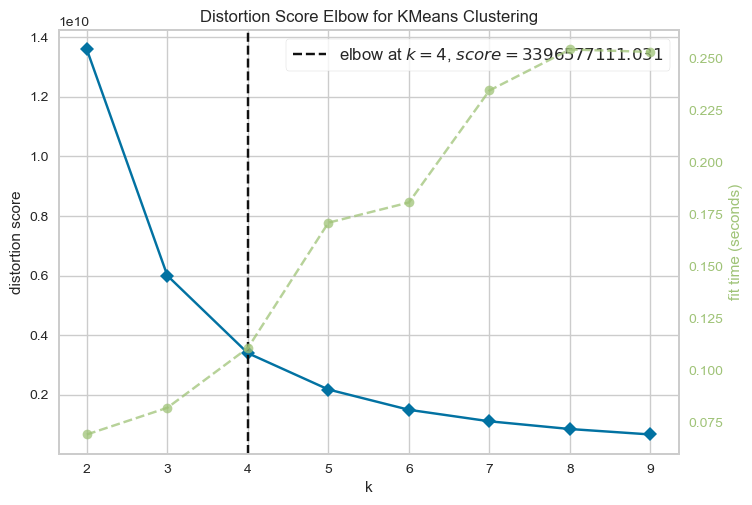

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [9]:
kmeans = KMeans(random_state=9)

visualizer = KElbowVisualizer(kmeans, k=(2,10))

visualizer.fit(data)

# display elbow plot
visualizer.show()

**Written answer (2 pts):**
Yes, we can, for this diagram it will be 4, but for better predictions we should look at digrams with different metrics.

2. Try between 2 and 6 clusters, using a seed of 9, and draw the silouhette plot for the K-means analysis. Report the silhouette scores. Do NOT use the built-in function `SilhouetteVisualizer()`.

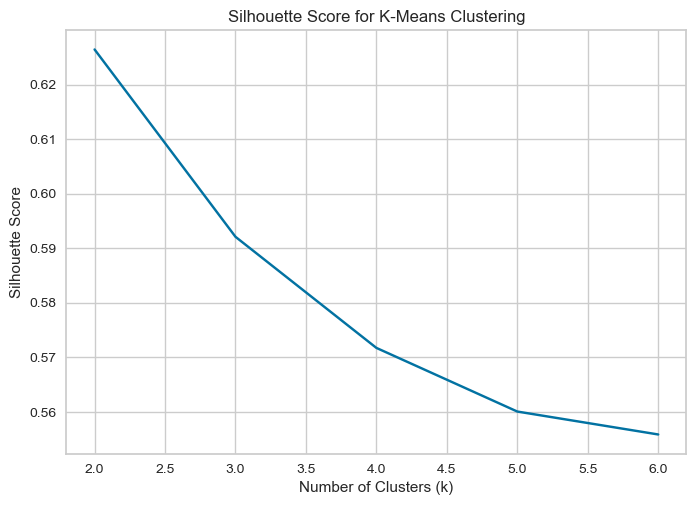

Silhouette Scores: [0.626454802813852, 0.5920985682805007, 0.5717230150526414, 0.5600504525372575, 0.5558466507684278]


In [10]:
k_range = range(2, 7)

silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=9)
    kmeans.fit(data)
    labels = kmeans.predict(data)
    score = silhouette_score(data, labels)
    silhouette_scores.append(score)

# plot silhouette scores for each k
plt.plot(k_range, silhouette_scores, 'bx-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-Means Clustering')
plt.show()

# print silhouette scores
print('Silhouette Scores:', silhouette_scores)

**What is the optimal number of clusters using the silhouette method?**
2 clusters have the highest score, on 3 and 4 we can see how the graph is getting less steep 


**ANSWER HERE (2pts):** 

3. Use the first and second principle components of the data as the x and y axis, draw the scatter plot where points are differentiated by clusters. Hints: you need to first perform dimension reduction with PCA using 2 components.

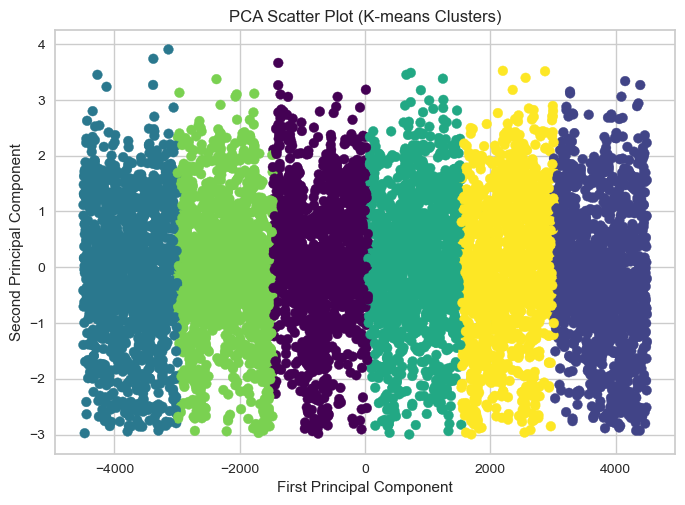

In [11]:

pca = PCA(n_components=2)
pca.fit(data)
X_pca = pca.transform(data)

# plot scatter plot of first two principal components, colored by cluster
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.title('PCA Scatter Plot (K-means Clusters)')
plt.show()


4. The objective of any cluster analysis over customer data is to create a reasonable segmentation of your customers. Using the number of clusters you have decided in Question 1, create a table (using `pandas.DataFrame.groupby`) of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Write a conclusion on the characteristics of each cluster.

In [12]:
kmeans = KMeans(n_clusters=4, random_state=9)
kmeans.fit(data[numerical_features])

data['cluster'] = kmeans.labels_
cluster_stats = data.groupby('cluster')[numerical_features].mean()

# display the resulting table
print(cluster_stats)

              Age  Work_Experience  Family_Size
cluster                                        
0        1.465317        -0.467156    -0.466071
1       -0.399506        -0.467944    -0.464888
2       -0.363902         1.793153    -0.243276
3       -0.477998        -0.384667     1.320957


**ANSWER HERE (2pts):** 

Cluster 0: older customers with smaller families and less work experience.

Cluster 1: younger customers with smaller families and less work experience.

Cluster 2: younger customers with more work experience and smaller families.

Cluster 3: younger customers with larger families.

## Question 3: Second Strategy (45 pts) 

1. First performing dimension reduction with PCA using 4 components. Look for the best number of clusters (between 3 to 6) using `Agglomerative clustering` with `affinity = 'cosine'` and `linkage = 'average'` and Silhuoette analysis.

In [13]:
pca = PCA(n_components=4)
df_pca = pca.fit_transform(data)

for n_clusters in range(3, 7):
    agc = AgglomerativeClustering(n_clusters=n_clusters, affinity='cosine', linkage='average')
    agc_labels = agc.fit_predict(df_pca)
    silhouette_avg = silhouette_score(df_pca, agc_labels, metric='euclidean')
    
    # print the number of clusters and the corresponding Silhouette score
    print(f"Number of clusters: {n_clusters}, Silhouette score: {silhouette_avg}")

Number of clusters: 3, Silhouette score: 0.17539638973877875
Number of clusters: 4, Silhouette score: 0.17510143114497512
Number of clusters: 5, Silhouette score: 0.1751515617481306
Number of clusters: 6, Silhouette score: 0.17497654850730188


**Written Answer:** How many clusters is select based on the previous results?

3


2. Graph the scatter plot of the PCA-transformed data differentiated by cluster. Use the first and second principal components of the data as the x and y axis.


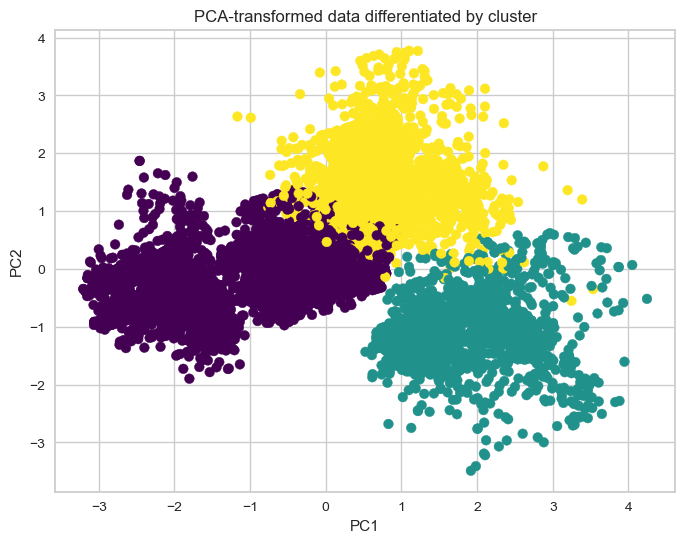

In [14]:
pca = PCA(n_components=3)
pca_data = pca.fit_transform(data.drop('ID', axis=1))

agg = AgglomerativeClustering(n_clusters=3)
agg_clusters = agg.fit_predict(pca_data)

# Create scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=agg_clusters, cmap='viridis')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA-transformed data differentiated by cluster')
plt.show()

3. Make the boxplot `Age` vs `Family_Size` based on the dataFrame before standardization, and use `hue = "Your_Cluster_Label"` in the plot function to show the differences among clusters.

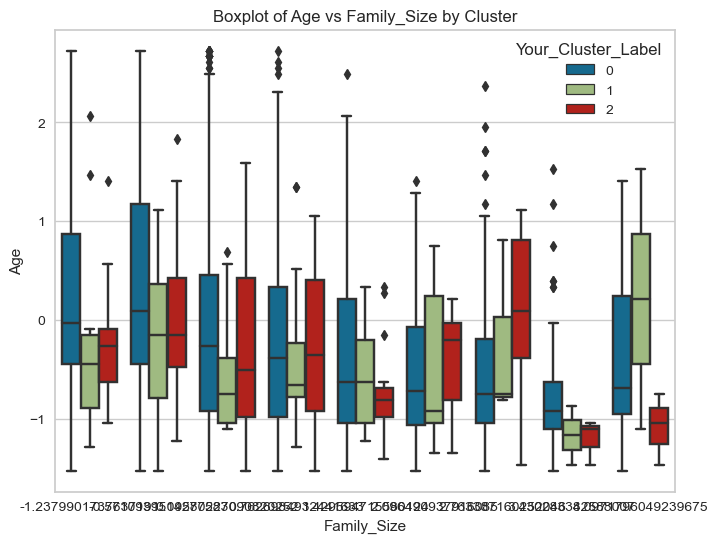

In [15]:
from sklearn.pipeline import Pipeline

cl_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('aggcl', AgglomerativeClustering(n_clusters=3, linkage="complete"))
])

plt.figure(figsize=(8, 6))
data['Your_Cluster_Label'] = cl_pipe.fit_predict(data)
sns.boxplot(x="Family_Size", y="Age", hue="Your_Cluster_Label", data=data)
plt.title("Boxplot of Age vs Family_Size by Cluster")
plt.show()

4. Using the number of clusters you have decided in Question 2 and `pandas.DataFrame.groupby`, create a table of the averages per variable (`Age`, `Work_Experience`, `Family_Size`) of each cluster (use the original, non-scaled, variables). Write a conclusion on the characteristics of each cluster.

In [16]:
cluster_avg = data.groupby('Your_Cluster_Label').mean()
print(cluster_avg)

                               ID       Age  Work_Experience  Family_Size  \
Your_Cluster_Label                                                          
0                   463478.326093  0.011672        -0.001448    -0.011433   
1                   463358.247059 -0.377137         0.103761     0.464557   
2                   463563.916256 -0.289418         0.012047     0.243636   

                    Gender_Male  Ever_Married_Yes  Graduated_Yes  \
Your_Cluster_Label                                                 
0                      0.550257          0.595116       0.627763   
1                      0.388235          0.482353       0.517647   
2                      0.507389          0.551724       0.581281   

                    Profession_Doctor  Profession_Engineer  \
Your_Cluster_Label                                           
0                            0.084576             0.086375   
1                            0.047059             0.105882   
2                        

**ANSWER HERE (2pts):** 

Cluster 0: a relatively high proportion of males, is older, and has higher spending scores.

Cluster 1: relatively younger, has more family members, and has a high proportion of people who have never been married.

Cluster 2: relatively older, has a high proportion of doctors, and a higher proportion of people in the "Other" profession category.
